In [1]:
pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
import fastdtw as fdt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras

In [3]:
from pmdarima.arima import auto_arima

In [4]:
path='/content/drive/MyDrive/Portfolio Project /demand-forecasting-kernels-only'

In [5]:
plt.rcParams['figure.figsize']=[16,10]

In [6]:
def symmetric_mean_absolute_percentage_error(forecast,actual):
  if not all([isinstance(forecast,np.ndarray),isinstance(actual,np.ndarray)]):
    forecast,actual=np.array(forecast),np.array(actual)
  smape=np.abs(forecast-actual)/((np.abs(forecast)+np.abs(actual))/2)
  smape=np.mean(smape)*100
  return round(smape,2)

In [7]:
#Dickey Fuller Stationary Test
def adfuller_test(series):
  result=adfuller(series)
  labels=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
  for value,label in zip(result,labels):
    print(label+' :'+str(value))
  
  if result[1]<0.05:
    print('Data is Stationary')
  else:
    print('Data is Non Stationary')

In [8]:
def ARIMA(TimeSeries, maxP, maxQ, maxD):
    stepwise_model = auto_arima(TimeSeries, start_p=1, start_q=1,
                           max_p=maxP, max_q=maxQ,
                           start_P=0, seasonal=True,
                           d=1, max_d=maxD, D=1, trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                           maxiter=500)
    print(stepwise_model.aic())
    return stepwise_model

In [9]:
def xgboost_model(x_train,y_train,x_test):
  dtrain=xgb.DMatrix(x_train,label=y_train,feature_names=list(x_train.columns))
  dtest=xgb.DMatrix(x_test,feature_names=list(x_test.columns))
  params = {'max_depth':3,'eta':0.2,'silent':1,'subsample':1}
  num_rounds = 1500
  bst = xgb.train(params, dtrain, num_rounds)  
  return pd.Series(bst.predict(dtest))

In [10]:
df = pd.read_csv(path +'/train.csv', index_col=0)

In [11]:
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [12]:
df.index=pd.to_datetime(df.index)

In [13]:
df.tail()

,store,item,sales
date,,,
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62
2017-12-31,10,50,82


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [15]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [16]:
store=pd.DataFrame(df.groupby(['date','store']).sum()['sales']).unstack()

In [17]:
store=store.resample('7D',label='left').sum()#goes by week

In [18]:
store

sales                                                          \
store          1      2      3      4      5      6      7      8      9    
date                                                                        
2013-01-01   9461  13209  11658  10918   7704   8025   7028  12684  10633   
2013-01-08   9325  13459  11959  10859   7898   7897   7316  12663  10869   
2013-01-15   9266  13306  11633  10778   7865   7851   7104  12754  10798   
2013-01-22   9247  13286  11871  10729   7782   7950   7271  12726  10957   
2013-01-29   9967  14210  12567  11743   8333   8453   7536  13402  11518   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2017-11-28  16256  23207  20455  19043  13727  13606  12642  22096  19006   
2017-12-05  14120  19732  17683  16350  11664  11719  10620  18986  16284   
2017-12-12  14085  19957  17798  16479  11836  11670  10820  18953  16331   
2017-12-19  14073  20204  17714  16362  11594  11728  10714  19120  16442   
2017-12-26  12439  17590  15823  14661  10525  10456   9680  16942  14496   

                   
store          10  
date               
2013-01-01  11516  
2013-01-08  11634  
2013-01-15  11558  
2013-01-22  11618  
2013-01-29  12448  
...           ...  
2017-11-28  20203  
2017-12-05  17479  
2017-12-12  17494  
2017-12-19  17302  
2017-12-26  15332  

[261 rows x 10 columns]

In [19]:
store.sort_index(inplace = True)

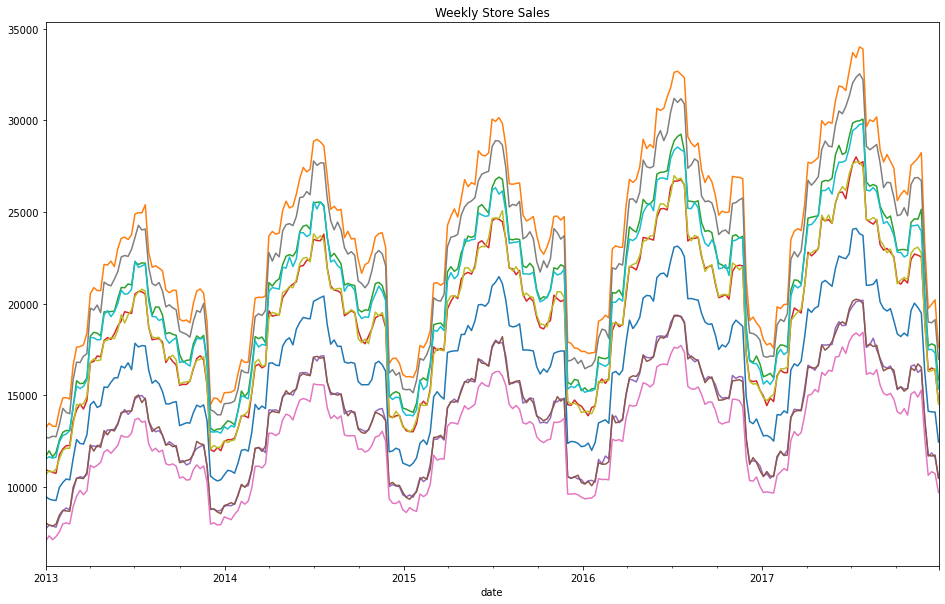

In [20]:
store.plot(figsize=(16,10), title='Weekly Store Sales', legend=None)
plt.show()

In [21]:
store_quantile=pd.DataFrame(store.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()

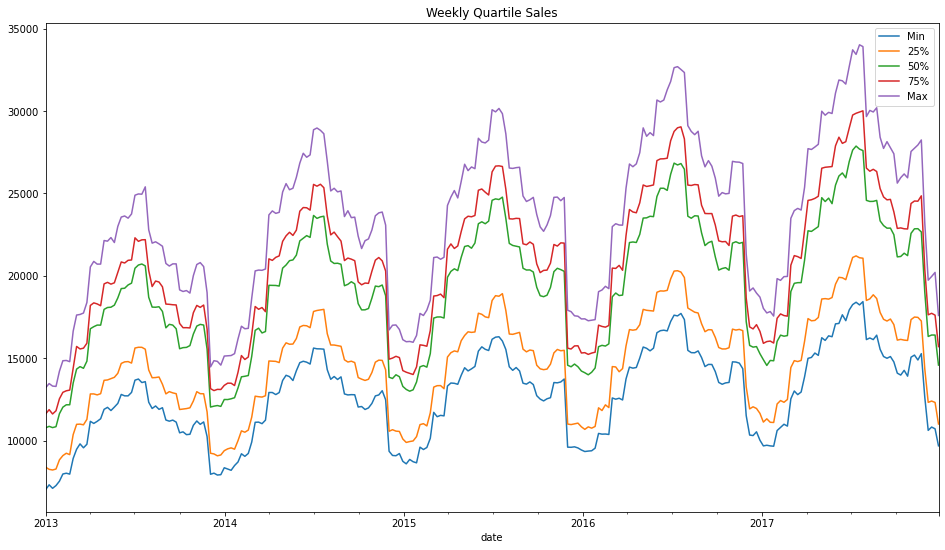

In [22]:
store_quantile.sort_index(inplace = True)
store_quantile.columns = ['Min','25%','50%','75%','Max']
store_quantile.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

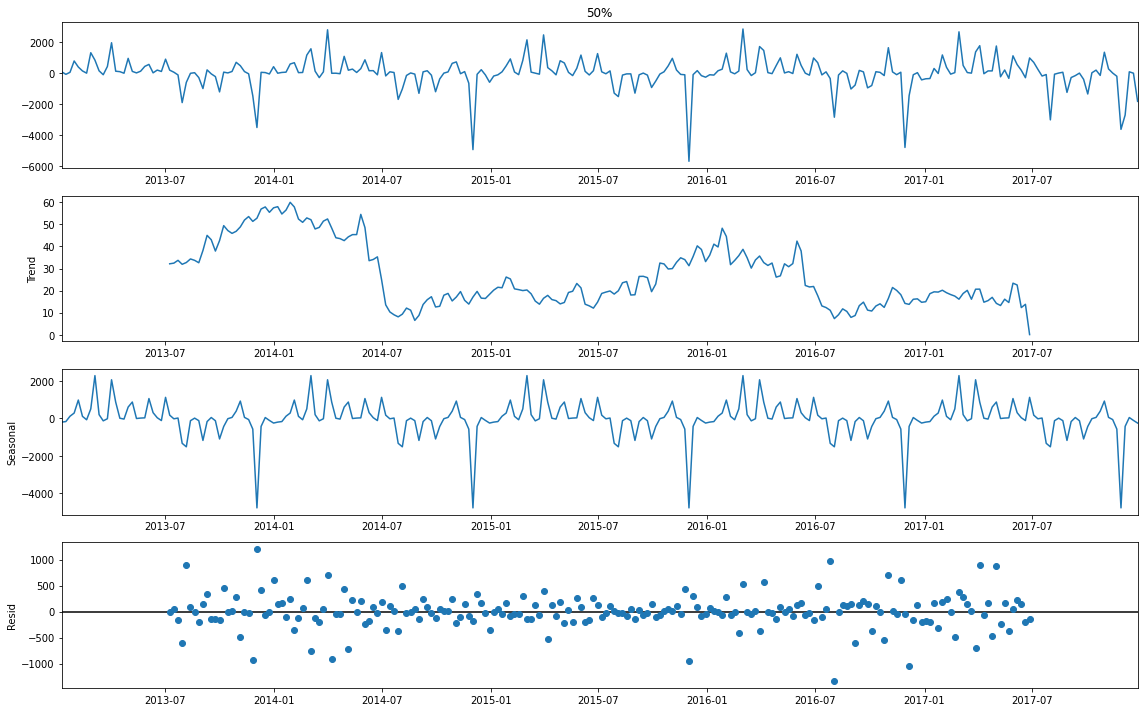

In [23]:
seasonal = seasonal_decompose(pd.DataFrame(store_quantile['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()

In [24]:
adfuller_test(pd.DataFrame(store_quantile['50%']).diff(1).iloc[1:,0])

ADF Test Statistic :-5.965888844671847
p-value :1.9882919872267362e-07
#Lags Used :3
Number of Observations Used :256
Data is Stationary


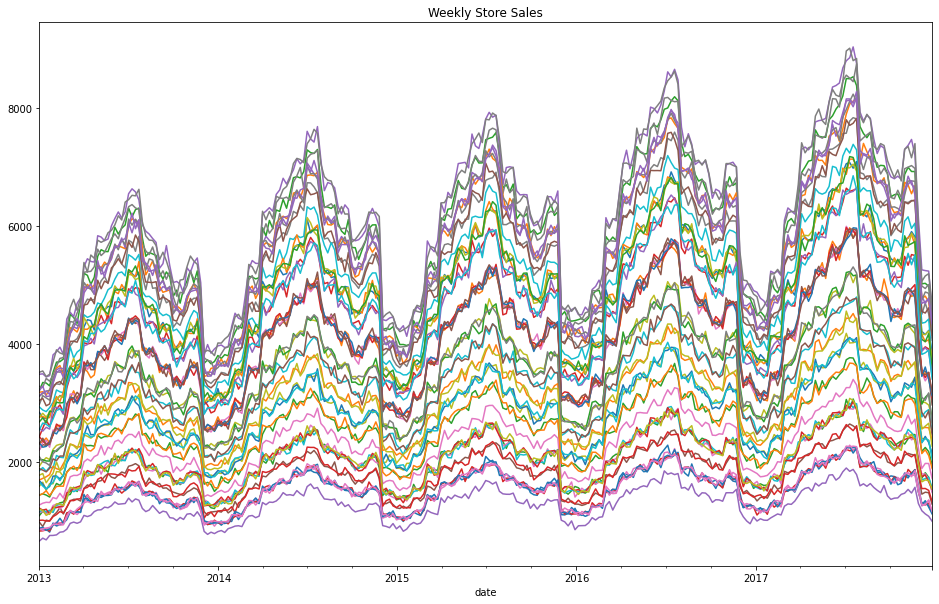

In [25]:
items = pd.DataFrame(df.groupby(['date','item']).sum()['sales']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)
items.plot(figsize=(16,10), title='Weekly Store Sales', legend=None)
plt.show()

In [26]:
item_quantile=pd.DataFrame(items.quantile([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],axis=1)).transpose()

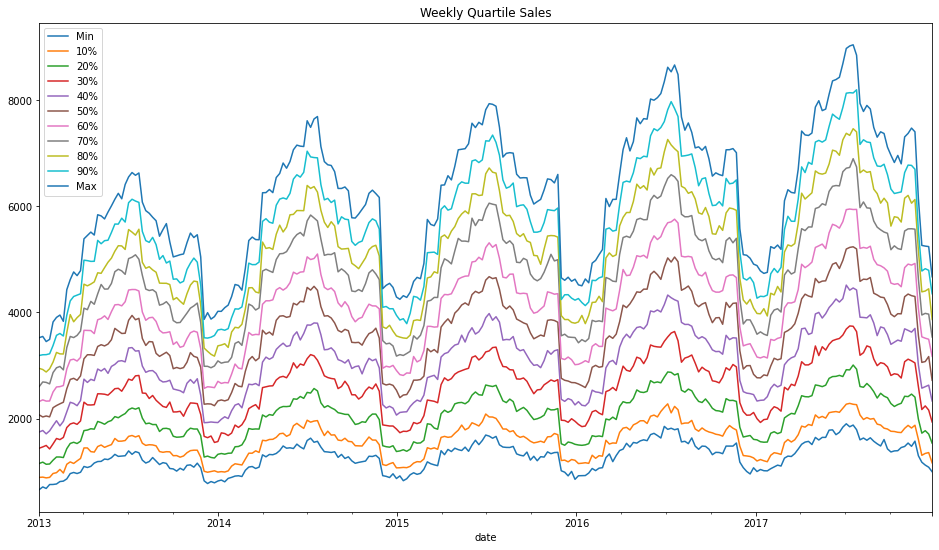

In [27]:
item_quantile.sort_index(inplace = True)
item_quantile.columns = ['Min','10%','20%','30%','40%','50%','60%','70%','80%','90%','Max']
item_quantile.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

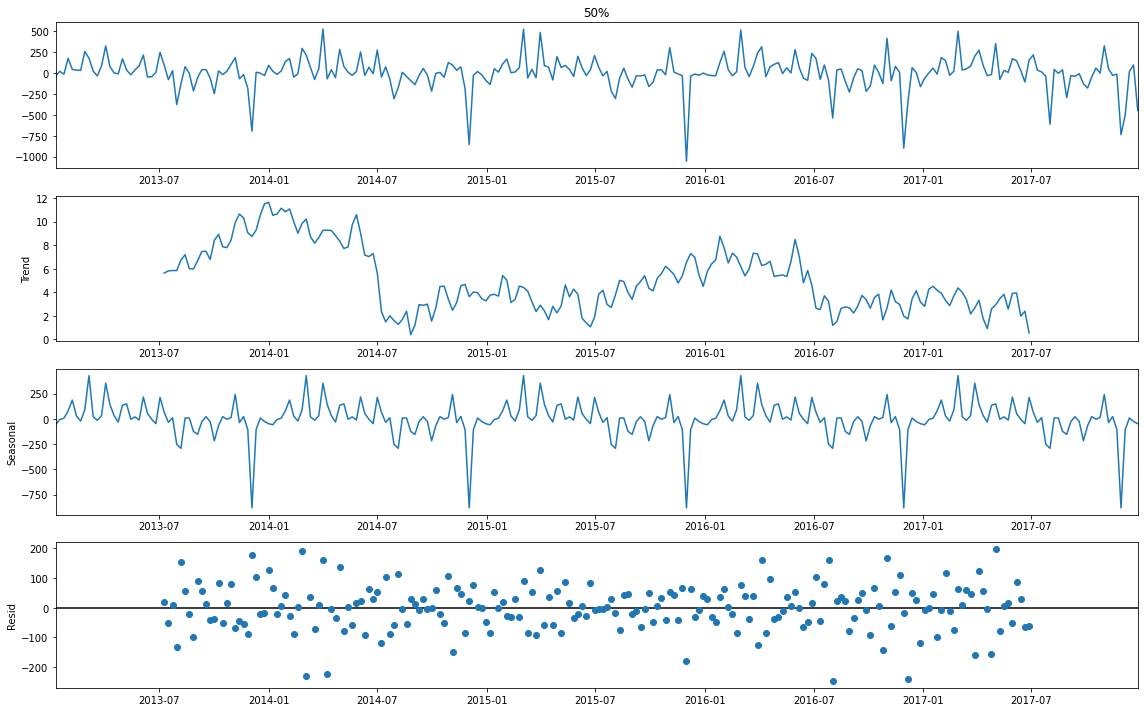

In [28]:
seasonal = seasonal_decompose(pd.DataFrame(item_quantile['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()

In [29]:
adfuller_test(pd.DataFrame(item_quantile['50%']).diff(1).iloc[1:,0])

ADF Test Statistic :-13.061788479850943
p-value :2.0402607112200708e-24
#Lags Used :0
Number of Observations Used :259
Data is Stationary


In [30]:
df.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(lambda x: 100*x/x.sum()).unstack()

store,1,2,3,4,5,6,7,8,9,10
item,,,,,,,,,,
1,9.085564,12.816904,11.405039,10.435394,7.615152,7.605435,6.896388,12.275527,10.611534,11.253064
2,9.073791,12.858324,11.405115,10.536256,7.595244,7.603005,6.951524,12.233490,10.549439,11.193814
3,9.062798,12.824640,11.399713,10.520157,7.596620,7.589895,6.967704,12.301689,10.516570,11.220215
4,9.066774,12.828092,11.411098,10.488994,7.622161,7.611960,6.977734,12.243629,10.517856,11.231703
5,9.049011,12.822540,11.361155,10.635385,7.672941,7.567640,6.936133,12.216389,10.497569,11.241237
6,9.069617,12.810300,11.453447,10.472900,7.617378,7.606987,6.957439,12.299760,10.497144,11.215027
7,9.018065,12.823723,11.386753,10.528670,7.608884,7.619737,6.955239,12.255129,10.560575,11.243225
8,9.028203,12.877231,11.373289,10.502894,7.610874,7.587459,6.981670,12.275640,10.563672,11.199068
9,9.049435,12.741440,11.381009,10.516433,7.557394,7.678561,6.986196,12.296844,10.528475,11.264212


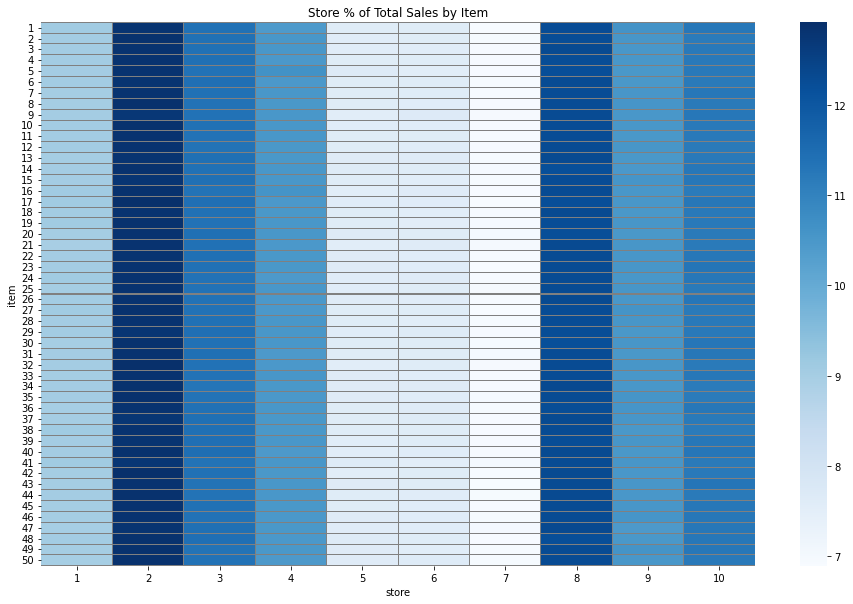

In [31]:
store_item = df.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(store_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Store % of Total Sales by Item')
plt.show()

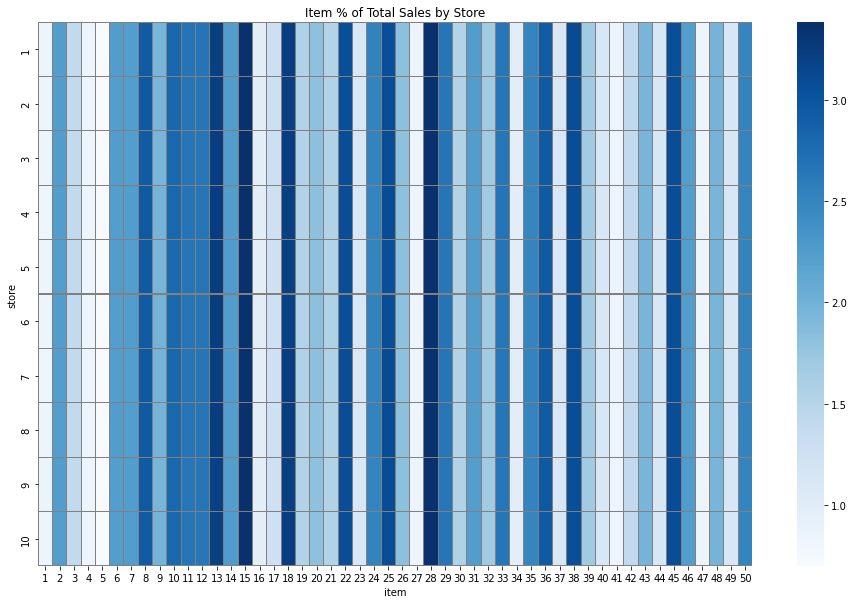

In [32]:
item_store = df.groupby(by=['store','item']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(item_store , cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Item % of Total Sales by Store')
plt.show()

In [33]:
df['Day']=df.index.day_name()

In [34]:
df.head()

,store,item,sales,Day
date,,,,
2013-01-01,1,1,13,Tuesday
2013-01-02,1,1,11,Wednesday
2013-01-03,1,1,14,Thursday
2013-01-04,1,1,13,Friday
2013-01-05,1,1,10,Saturday


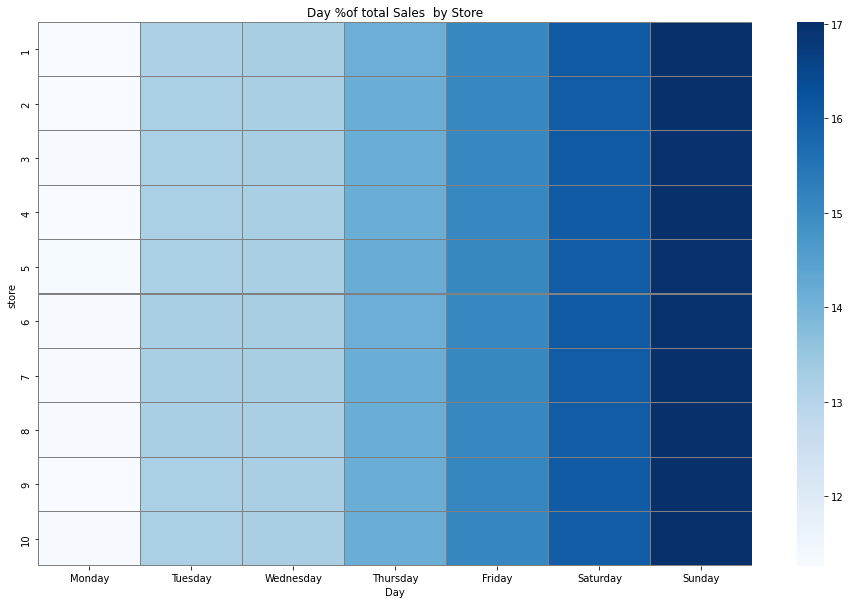

In [35]:
dow_store=df.groupby(['store','Day']).sum()['sales'].groupby(level=0).apply(lambda x: 100*x/x.sum()).unstack().loc[:,['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
sns.heatmap(dow_store,cmap='Blues',linewidths=0.01,linecolor='gray').set_title('Day %of total Sales  by Store')
plt.show()

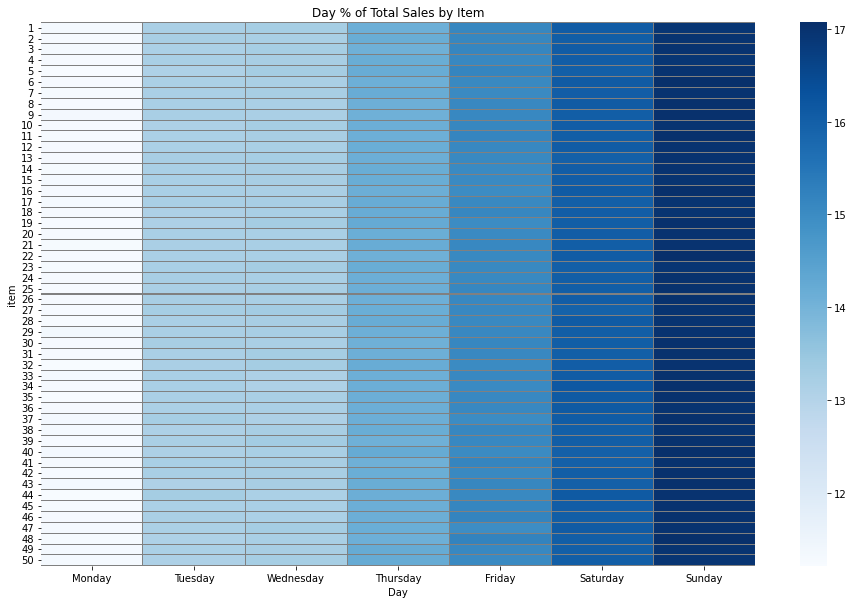

In [36]:
dow_item = df.groupby(['item','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title('Day % of Total Sales by Item')
plt.show()

In [37]:
dow = pd.DataFrame(df.groupby(['date','Day']).sum()['sales']).unstack()['sales'].loc[:,
                                                                                ['Monday',
                                                                               'Tuesday',
                                                                               'Wednesday',
                                                                               'Thursday',
                                                                               'Friday',
                                                                               'Saturday',
                                                                               'Sunday']]
dow = dow.resample('7D',label='left').sum()
dow.sort_index(inplace = True)

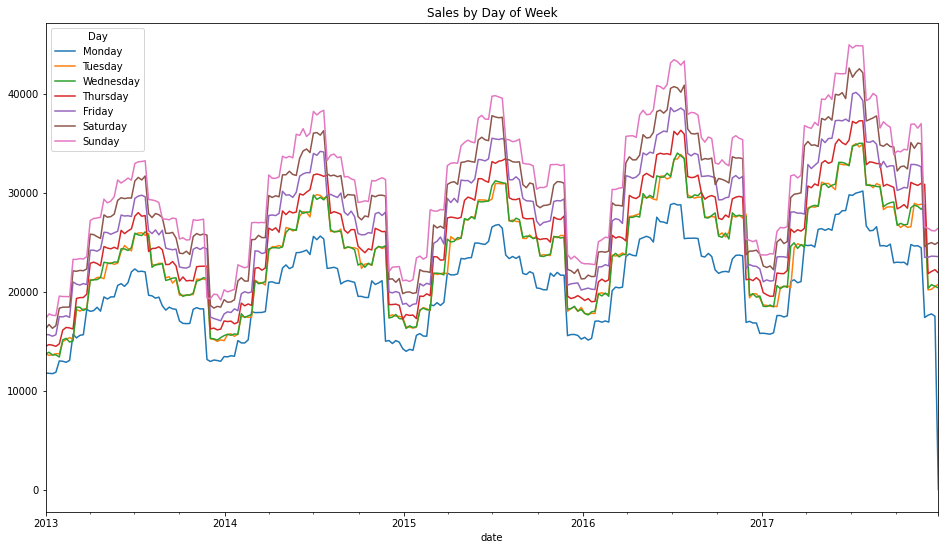

In [38]:
dow.plot(figsize=(16,9), title='Sales by Day of Week')
plt.show()

In [39]:
train=item_quantile[:-13]
test=df.loc[df.index>=pd.to_datetime('October 3, 2017')]

In [40]:
train.head()

,Min,10%,20%,30%,40%,50%,60%,70%,80%,90%,Max
date,,,,,,,,,,,
2013-01-01,664.0,893.1,1156.8,1443.7,1749.2,2069.0,2324.0,2605.9,2946.0,3190.0,3526.0
2013-01-08,714.0,898.3,1180.4,1467.4,1776.6,2031.5,2353.6,2691.4,2925.4,3203.4,3548.0
2013-01-15,685.0,884.1,1140.6,1495.1,1713.6,2050.0,2330.2,2682.8,2878.8,3205.2,3452.0
2013-01-22,759.0,893.5,1145.8,1429.2,1770.0,2033.5,2332.6,2654.7,2938.6,3221.9,3493.0
2013-01-29,760.0,966.8,1217.6,1524.7,1867.6,2206.5,2502.8,2868.1,3065.4,3377.8,3821.0


In [41]:
test.head()

,store,item,sales,Day
date,,,,
2017-10-03,1,1,18,Tuesday
2017-10-04,1,1,15,Wednesday
2017-10-05,1,1,20,Thursday
2017-10-06,1,1,19,Friday
2017-10-07,1,1,22,Saturday


In [42]:
store_pct = store_item.transpose()

In [43]:
store_pct.head()

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,
1,9.085564,9.073791,9.062798,9.066774,9.049011,9.069617,9.018065,9.028203,9.049435,9.061402,...,9.091271,9.023547,9.015145,9.046201,9.024192,9.011790,9.005155,9.063957,9.020410,9.007414
2,12.816904,12.858324,12.824640,12.828092,12.822540,12.810300,12.823723,12.877231,12.741440,12.850031,...,12.757648,12.910997,12.825060,12.853127,12.828966,12.827383,12.810710,12.857803,12.855471,12.844459
3,11.405039,11.405115,11.399713,11.411098,11.361155,11.453447,11.386753,11.373289,11.381009,11.387498,...,11.357555,11.392619,11.345828,11.356511,11.398149,11.382714,11.416667,11.430911,11.337725,11.377637
4,10.435394,10.536256,10.520157,10.488994,10.635385,10.472900,10.528670,10.502894,10.516433,10.521691,...,10.529945,10.504758,10.531103,10.528659,10.509172,10.474110,10.504977,10.469840,10.513140,10.461351
5,7.615152,7.595244,7.596620,7.622161,7.672941,7.617378,7.608884,7.610874,7.557394,7.580473,...,7.649611,7.558458,7.634991,7.624657,7.622733,7.628759,7.589458,7.649330,7.626250,7.637765


In [44]:
items.head()

sales                                                      ...  \
item          1     2     3    4    5     6     7     8     9     10  ...   
date                                                                  ...   
2013-01-01   894  2320  1444  834  664  2214  2207  2978  1934  2938  ...   
2013-01-08   863  2348  1466  839  714  2299  2335  3130  2019  2886  ...   
2013-01-15   867  2411  1444  854  685  2286  2371  3091  2078  2859  ...   
2013-01-22   816  2331  1411  836  759  2296  2255  3053  2046  2926  ...   
2013-01-29   969  2470  1528  939  760  2485  2547  3305  2218  3016  ...   

                                                                      
item         41    42    43    44    45    46   47    48    49    50  
date                                                                  
2013-01-01  873  1443  2043  1223  3130  2313  861  2095  1206  2550  
2013-01-08  901  1468  2044  1188  3180  2408  874  2008  1183  2665  
2013-01-15  846  1517  2022  1204  3207  2299  886  1988  1101  2645  
2013-01-22  871  1437  2021  1122  3152  2305  895  1946  1133  2601  
2013-01-29  931  1517  2195  1240  3338  2496  943  2144  1204  2735  

[5 rows x 50 columns]

In [45]:
fitted_items_WK=[]
qtr_list=[0]*11

In [46]:
for columns in items:
  for c in range(11):
    qtr_list[c] = [fdt.fastdtw(items[columns],item_quantile.iloc[:,c], dist= euclidean)[0], c]
  qtr_list.sort()
  fitted_items_WK.append([columns[1], qtr_list[0][1], qtr_list[0][0]])

In [47]:
fitted_items_WK

[[1, 1, 9738.800000000005],
 [2, 6, 11984.400000000003],
 [3, 3, 6570.300000000008],
 [4, 1, 9412.89999999999],
 [5, 0, 0.0],
 [6, 6, 11718.799999999994],
 [7, 6, 11889.999999999996],
 [8, 8, 41115.59999999997],
 [9, 5, 9677.5],
 [10, 8, 11448.800000000156],
 [11, 7, 34868.20000000003],
 [12, 7, 34362.60000000007],
 [13, 9, 46035.99999999998],
 [14, 6, 10698.400000000012],
 [15, 10, 9703.0],
 [16, 1, 33976.10000000001],
 [17, 3, 38448.2],
 [18, 9, 45467.69999999998],
 [19, 3, 37351.799999999996],
 [20, 4, 36399.80000000001],
 [21, 3, 35215.3],
 [22, 9, 12069.50000000001],
 [23, 2, 6993.999999999996],
 [24, 7, 20863.69999999993],
 [25, 9, 12354.899999999992],
 [26, 4, 37119.0],
 [27, 1, 8691.4],
 [28, 10, 12004.0],
 [29, 7, 33302.800000000025],
 [30, 3, 37312.300000000025],
 [31, 6, 10485.999999999995],
 [32, 4, 7476.199999999999],
 [33, 7, 33233.300000000054],
 [34, 1, 36499.59999999997],
 [35, 7, 24396.399999999936],
 [36, 8, 42074.39999999993],
 [37, 2, 6630.000000000004],
 [38, 9, 1

#Clustered Weekly Data#

In [ ]:
ARIMA_preds=pd.DataFrame()
for column in item_quantile:
  model=ARIMA(item_quantile[column],52,52,52)
  model.fit(train[column])
  ARIMA_preds[column]=model.predict(n_periods=13)

In [ ]:
ARIMA_preds[:10]

In [ ]:
item_WK_predictions = pd.DataFrame()
for i in range(50):
    item_WK_predictions[fitted_items_WK[i][0]] = ARIMA_preds.iloc[:,fitted_items_WK[i][1]]
item_WK_predictions.head()

In [ ]:
item_day_pred=[]
for column in item_WK_predictions:
  for i,row in item_WK_predictions.iterrows():
    for col in range(7):
      item_day_pred.append([i, dow_item.columns[col], column, dow_item.iloc[int(column)-1,col]*item_WK_predictions[column][i]/100])      
item_day_fcst = pd.DataFrame(item_day_pred, columns=['Week #','Day','item','Prediction'])
item_day_fcst.head()

In [ ]:
store_item = pd.DataFrame(store_item.stack()).reset_index()
store_item.columns = ['item','store','pct']
item_day_fcst = item_day_fcst.merge(store_item, on= 'item')

In [ ]:
item_day_fcst.head()

In [ ]:
item_day_fcst['Prediction']=item_day_fcst['Prediction'].apply(pd.to_numeric)

In [ ]:
item_day_fcst['sales'] = item_day_fcst['Prediction'] * item_day_fcst['pct']/100

In [ ]:
item_day_fcst = item_day_fcst.loc[:,['Week #','Day','store','item','sales']]
item_day_fcst.head()

In [ ]:
def str_to_date(row):
    switcher = {
        'Tuesday': 0, #data starts on a Tuesday, so 0 offset
        'Wednesday': 1,
        'Thursday': 2,
        'Friday': 3,
        'Saturday': 4,
        'Sunday': 5,
        'Monday': 6
    }
    weeks = pd.to_timedelta(7* row['Week #'], unit='D')
    days = pd.to_timedelta(switcher.get(row['Day']), unit='D')
    
    return pd.to_datetime('October 3, 2017') + weeks + days


item_day_fcst['Date'] = item_day_fcst.apply(lambda row: str_to_date(row), axis=1)
item_day_fcst.index = item_day_fcst['Date']

In [ ]:
item_day_fcst.drop('Date',axis=1,inplace=True)

In [ ]:
item_day_fcst.head()

In [ ]:
item_day_fcst.sort_values(['item','store','Date'], inplace=True)
item_day_fcst['sales']= round(item_day_fcst['sales'], 0)
item_Day_fcst = item_day_fcst[['store','item','sales']].loc[item_day_fcst.index < pd.to_datetime('January 1, 2018')]

In [ ]:
symmetric_mean_absolute_percentage_error(item_Day_fcst['sales'], test['sales'])

#Unclustered Weekly Data#

In [ ]:
train = items['sales'][:-13]

In [ ]:
item_WK_predictions = pd.DataFrame()
for column in items['sales']:
    model = ARIMA(items['sales'][column], 52, 52, 52)
    model.fit(train[column])
    item_WK_predictions[column] = model.predict(n_periods=13)

In [ ]:
item_Day_pred = []

for column in item_WK_predictions:
    for i, row in item_WK_predictions.iterrows():
        for col in range(7):
            item_Day_pred.append([i, dow_item.columns[col], column, dow_item.iloc[int(column)-1,col]
                                 * item_WK_predictions[column][i]/100])
            
item_Day_fcst = pd.DataFrame(item_Day_pred, columns=['Week #','Day','item','Prediction'])

item_Day_fcst.head()

In [65]:
item_Day_fcst = item_Day_fcst.merge(store_item, on= 'item')

item_Day_fcst['sales'] = item_Day_fcst['Prediction'] * item_Day_fcst['pct']/100

In [66]:
item_Day_fcst = item_Day_fcst.loc[:,['Week #','Day','store','item','sales']]

In [67]:
item_Day_fcst['Date'] = item_Day_fcst.apply(lambda row: str_to_date(row), axis=1)
item_Day_fcst.index = item_Day_fcst['Date']

In [68]:
item_Day_fcst.drop('Date',axis=1,inplace=True)

In [69]:
item_Day_fcst.sort_values(['item','store','Date'], inplace=True)
item_Day_fcst['sales']= round(item_Day_fcst['sales'], 0)

item_Day_fcst = item_Day_fcst[['store','item','sales']].loc[
    item_Day_fcst.index < pd.to_datetime('January 1, 2018')]

In [70]:
symmetric_mean_absolute_percentage_error(item_Day_fcst['sales'], test['sales'])

19.01

#Creating Dataframe for Training and Testing in Machine Learning and Deep Learning Models#

In [48]:
ns_per_day = 86400000000000
start_date = pd.to_datetime('January 1, 2013')

In [49]:
itm_quart = pd.DataFrame(fitted_items_WK, columns=['item','item_quart','item_metric'])#which quartile the item trend resemble most

In [50]:
def add_feat(df, train_end_str):    
    dataf = df
    dataf['Weekday'] = dataf.index.dayofweek
    dataf['Is_Mon'] = (dataf.index.dayofweek == 0) *1
    dataf['Is_Tue'] = (dataf.index.dayofweek == 1) *1
    dataf['Is_Wed'] = (dataf.index.dayofweek == 2) *1
    dataf['Is_Thu'] = (dataf.index.dayofweek == 3) *1
    dataf['Is_Fri'] = (dataf.index.dayofweek == 4) *1
    dataf['Is_Sat'] = (dataf.index.dayofweek == 5) *1
    dataf['Is_Sun'] = (dataf.index.dayofweek == 6) *1
    dataf['Is_wknd'] = dataf.index.dayofweek // 4 # Fri-Sun are 4-6, Monday is 0 so this is valid
    dataf['Day_Num'] = ((dataf.index - start_date)/ ns_per_day).astype(int)
    
    dataf['Month'] = dataf.index.month
    dataf['Day_of_Year'] = ((dataf.index - start_date)/ ns_per_day).astype(int) % 364
    dataf['Year'] = ((dataf.index - start_date)/ ns_per_day).astype(int) // 364 -1
    dataf['Day_of_Quarter'] = ((dataf.index - start_date)/ ns_per_day).astype(int) % 91
    dataf['Quarter'] = (((dataf.index - start_date)/ ns_per_day).astype(int) // 91) % 4
    dataf.reset_index(inplace=True)
    
    # Add item quartile as feature
    dataf = dataf.merge(itm_quart, on='item').drop('item_metric', axis=1)

    # Add prior year sales as additional feature
    prior_year_sales = dataf[['date','sales','store','item']]
    prior_year_sales['date'] += pd.Timedelta('364 days')
    prior_year_sales.columns =['date','lag_12mo','store','item']

    dataf = dataf.merge(prior_year_sales, on=['date','store','item'])
    
    # Add average by item by store by day of year as additional feature
    avg = dataf.loc[df['date'] < pd.to_datetime(train_end_str), ['Day_of_Year','sales','store','item']].groupby(by=['Day_of_Year','store','item']).mean().reset_index()
    avg.columns =['Day_of_Year','store','item','DoY_Mean']
    
    dataf = dataf.merge(avg, on=['Day_of_Year','store','item'])
    
    # Add average by day of week by quarter by item by store as additional feature
    avg = dataf.loc[df['date'] < pd.to_datetime(train_end_str), ['Quarter','Weekday','sales','store','item']].groupby(by=['Quarter','Weekday','store','item']).mean().reset_index()
    avg.columns =['Quarter','Weekday','store','item','DoW_Mean']
    
    dataf = dataf.merge(avg, on=['Quarter','Weekday','store','item'])
    
    # Id's start at 0 instead of 1
    dataf['store'] -=1
    dataf['item'] -=1
    
    # Remove first year of data as there is no prior year sales for them, then sort to match competition id's
    dataf = dataf[dataf['Year'] >=0].drop('Year', axis=1).sort_values(['item','store','date'])
    
    return dataf


In [51]:
df_test = add_feat(df, 'October 3, 2017') # Takes average of training data
df_test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.p

,date,store,item,sales,Day,Weekday,Is_Mon,Is_Tue,Is_Wed,Is_Thu,...,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,item_quart,lag_12mo,DoY_Mean,DoW_Mean
0,2013-12-31,0,0,15,Tuesday,1,0,1,0,0,...,0,364,12,0,0,0,1,13,12.8,13.735849
53,2014-01-01,0,0,9,Wednesday,2,0,0,1,0,...,0,365,1,1,1,0,1,11,13.2,16.132075
106,2014-01-02,0,0,14,Thursday,3,0,0,0,1,...,0,366,1,2,2,0,1,14,16.6,15.943396
159,2014-01-03,0,0,11,Friday,4,0,0,0,0,...,1,367,1,3,3,0,1,13,18.0,17.075472
212,2014-01-04,0,0,20,Saturday,5,0,0,0,0,...,1,368,1,4,4,0,1,10,18.0,17.283019


In [52]:
df_test.tail()

,date,store,item,sales,Day,Weekday,Is_Mon,Is_Tue,Is_Wed,Is_Thu,...,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,item_quart,lag_12mo,DoY_Mean,DoW_Mean
729595,2017-12-27,9,49,63,Wednesday,2,0,0,1,0,...,0,1821,12,1,1,0,7,43,46.8,54.924528
729648,2017-12-28,9,49,59,Thursday,3,0,0,0,1,...,0,1822,12,2,2,0,7,68,54.6,59.943396
729701,2017-12-29,9,49,74,Friday,4,0,0,0,0,...,1,1823,12,3,3,0,7,63,60.0,64.075472
729754,2017-12-30,9,49,62,Saturday,5,0,0,0,0,...,1,1824,12,4,4,0,7,64,59.2,67.603774
729807,2017-12-31,9,49,82,Sunday,6,0,0,0,0,...,1,1825,12,5,5,0,7,69,69.6,70.811321


In [53]:
df_test.shape

(731000, 23)

In [54]:
x_train = df_test.loc[df['date'] < pd.to_datetime('October 3, 2017')].drop(['sales','date','Day', 'Weekday'], axis=1)
y_train = df_test.loc[df['date'] < pd.to_datetime('October 3, 2017'), 'sales']
x_test = df_test.loc[df['date'] >= pd.to_datetime('October 3, 2017')].drop(['sales','date','Day', 'Weekday'], axis=1).reset_index(drop=True)
y_test = df_test.loc[df['date'] >= pd.to_datetime('October 3, 2017'), 'sales'].reset_index(drop=True)

In [55]:
x_train.head()

,store,item,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,item_quart,lag_12mo,DoY_Mean,DoW_Mean
0,0,0,0,1,0,0,0,0,0,0,364,12,0,0,0,1,13,12.8,13.735849
53,0,0,0,0,1,0,0,0,0,0,365,1,1,1,0,1,11,13.2,16.132075
106,0,0,0,0,0,1,0,0,0,0,366,1,2,2,0,1,14,16.6,15.943396
159,0,0,0,0,0,0,1,0,0,1,367,1,3,3,0,1,13,18.0,17.075472
212,0,0,0,0,0,0,0,1,0,1,368,1,4,4,0,1,10,18.0,17.283019


In [56]:
x_train.shape

(695000, 19)

#XGBOOST#

In [58]:
xgmodel=xgb.XGBRegressor()
xgmodel.fit(x_train,y_train)

[11:35:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [59]:
preds = xgmodel.predict(x_test)

In [60]:
symmetric_mean_absolute_percentage_error(preds, y_test)

10.49

In [61]:
x_train.shape

(695000, 19)

#Neural Network Model#

In [62]:
input=tf.keras.layers.Input(shape=(19))

In [63]:
x=tf.keras.layers.Dense(32,activation='relu')(input)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.Dense(32,activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(8,activation='relu')(x)
output=tf.keras.layers.Dense(1,activation='relu')(x)

In [64]:
model=tf.keras.models.Model(inputs=input,outputs=output)

In [65]:
model.compile(optimizer='adam',loss='mae')

In [66]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense (Dense)               (None, 32)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                             

In [67]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
21719/21719 [==============================] - 137s 6ms/step - loss: 6.8043
Epoch 2/10
21719/21719 [==============================] - 128s 6ms/step - loss: 5.5050
Epoch 3/10
21719/21719 [==============================] - 132s 6ms/step - loss: 5.3123
Epoch 4/10
21719/21719 [==============================] - 125s 6ms/step - loss: 5.2453
Epoch 5/10
21719/21719 [==============================] - 123s 6ms/step - loss: 5.1976
Epoch 6/10
21719/21719 [==============================] - 124s 6ms/step - loss: 5.1631
Epoch 7/10
21719/21719 [==============================] - 124s 6ms/step - loss: 5.1370
Epoch 8/10
21719/21719 [==============================] - 124s 6ms/step - loss: 5.1328
Epoch 9/10
21719/21719 [==============================] - 124s 6ms/step - loss: 5.1058
Epoch 10/10
21719/21719 [==============================] - 123s 6ms/step - loss: 5.0886


In [69]:
preds=model.predict(x_test)

In [ ]:
symmetric_mean_absolute_percentage_error(preds, y_test)